## Import model and necessary libraries

In [ ]:
from facenet_pytorch import InceptionResnetV1
import torch
from PIL import Image
from torchvision import transforms
import os

model = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

## Create an embedding function

In [2]:
def create_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((160, 160)) 
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        input_tensor = normalize(image).unsqueeze(0)

        with torch.no_grad():
            embeddings = model(input_tensor)
        return embeddings.squeeze().numpy()
    except Exception as e:
        print("Error:", e)
        return None

## Importing image vector data

In [ ]:
root_folder = "./images/" 

embeddings = []
image_names = []
pk_values = []  

pk_counter = 0

for foldername, subfolders, filenames in os.walk(root_folder):
    for filename in filenames:
        if filename.endswith(".jpg"):
            file_path = os.path.join(foldername, filename)
            
            var_name = os.path.splitext(filename)[0] 
            
            image_name = file_path
            
            image_names.append(image_name)  
            
            embedding = create_image_embedding(file_path)
            embeddings.append(embedding)
            
            pk_values.append(pk_counter)
            pk_counter += 1
            
            exec(f"{var_name} == embedding")
            
            print(f"Image Embedding Shape for {image_name}: {embedding.shape}")

words = image_names
primary_keys = pk_values
data = [primary_keys,words, embeddings]


In [4]:
len(data[2])

203

## Import milvus libraries and make a settings for database

In [6]:
from pymilvus import (
    connections,
    utility,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
)

In [44]:
connections.connect("default", host="localhost", port="19530")

In [8]:
fields = [
    FieldSchema(name="pk", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="words", dtype=DataType.VARCHAR, max_length=50),
    FieldSchema(name="embeddings", dtype=DataType.FLOAT_VECTOR, dim=512)
]
schema = CollectionSchema(fields, "Image Embeddings Collection")
face_detection = Collection("face_detection", schema)

In [ ]:
index = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128},
}
face_detection.create_index("embeddings", index)

## Insert data to db

In [10]:
face_detection.insert(data)
face_detection.flush()
face_detection.load()

## Import test image vector data

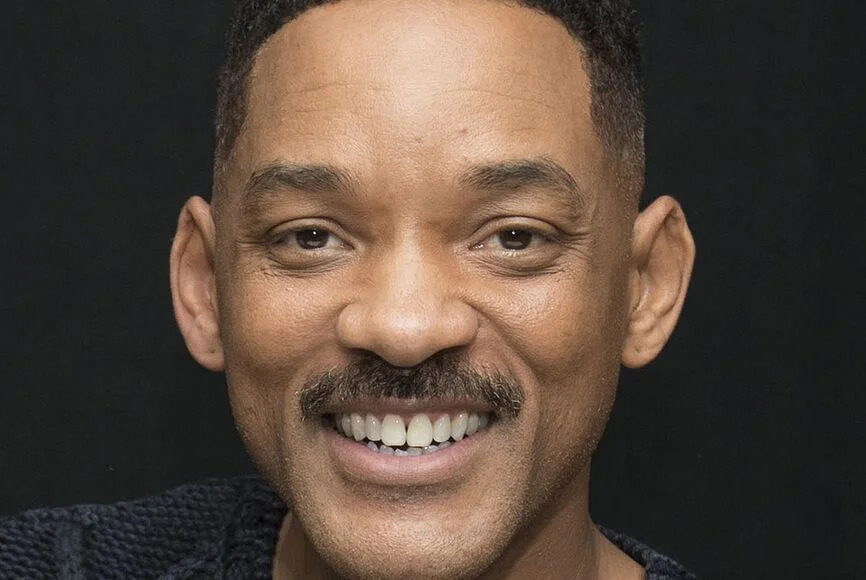

In [42]:
query_image_filename = "./test_images/images_3.jpg."
query_embedding = create_image_embedding(query_image_filename)

display(Image.open(f'{query_image_filename}'))

## Vector search query

In [45]:
search_params = {"metric_type": "L2"}

results = face_detection.search(
    data=[query_embedding],
    anns_field="embeddings",
    param=search_params,
    limit=5,
    expr=None,
    output_fields=['words'],
    consistency_level="Strong"
)

In [46]:
print(results[0].ids)
print(results[0].distances)

[57, 35, 101, 148, 13]
[0.5878466963768005, 0.599678635597229, 0.6069260835647583, 0.6218627095222473, 0.6220566034317017]


In [47]:
hit = results[0][0]
hit.entity.get('words')

'./images/15.jpg'

## Show search query results images

./images/15.jpg


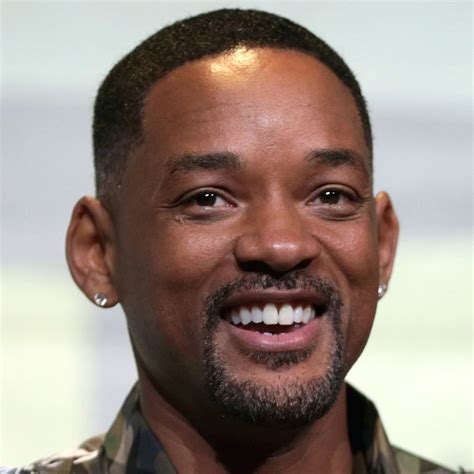

./images/13.jpg


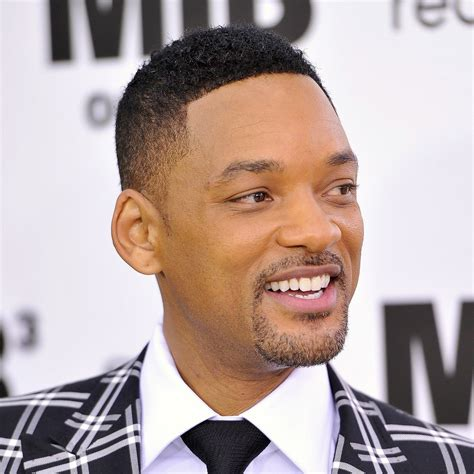

./images/19.jpg


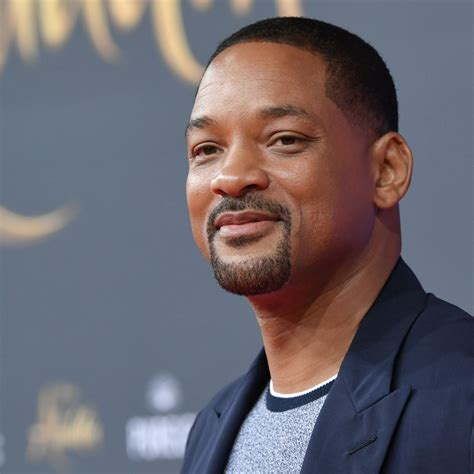

./images/5.jpg


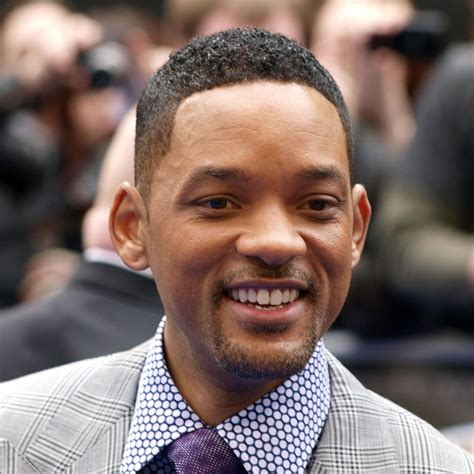

./images/11.jpg


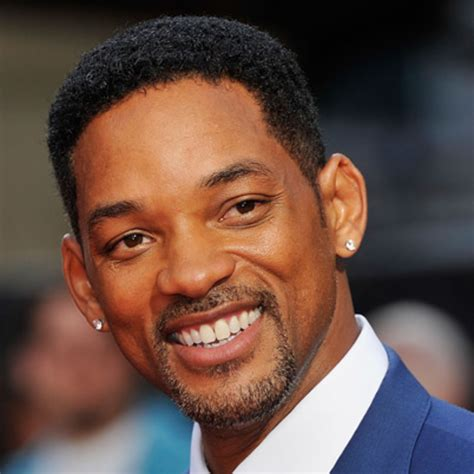

In [48]:
for i in range(0, len(results[0])):
    name = str(results[0][i].entity.get('words'))
    print(name)
    display(Image.open(f'{name}'))


## Disconnect to db

In [50]:
connections.disconnect(alias="default")